# PID-Reglerentwurf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display, Image, Latex, Markdown
from scipy.integrate import solve_ivp

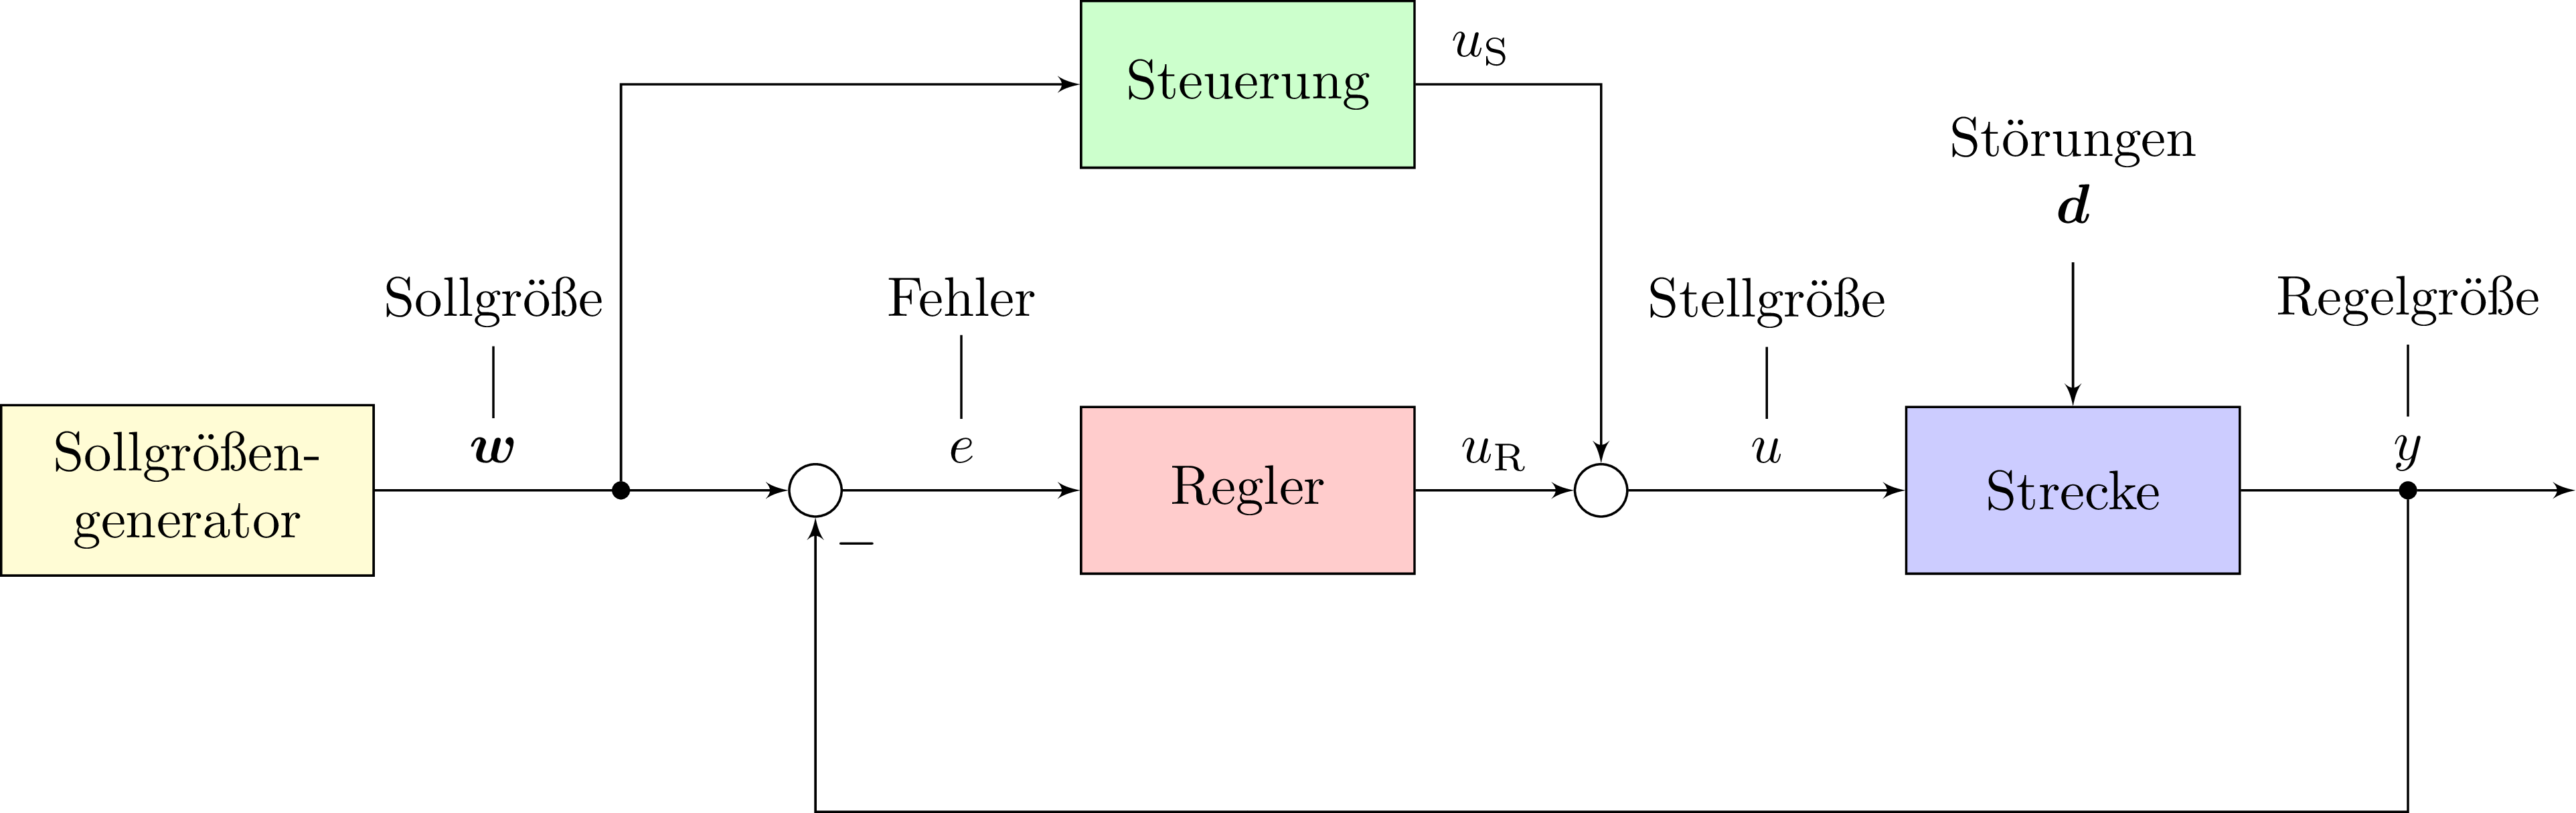

In [2]:
imag = Image("../images/feedBackGenerator.png", width=600)
display(imag)

Ziel ist der Entwurf eines PI-Reglers auf Basis des linearisierten Modells des Zweitanksystems
\begin{align*}
    T_1 T_2 \ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = K \tilde{u}_{\mathrm{A}}(t)
\end{align*}
unter Verwendung des Betragsoptimumsverfahrens zum Einstellen der Reglerparameter.
Bei dieser Methode wird
\begin{align*}
    |G(j\omega)| & = 1 & \Leftrightarrow && |G(j \omega)|_{\textrm{dB}} & = 0, & \forall \omega & \ge 0
\end{align*}
gefordert.
Es wird mittels der Integratorzeitkonstante $T_{\mathrm{I}}$ des Reglers die größte Zeitkonstante der Strecke kompensiert und durch die Verstärkung $K_{\mathrm{P}}$ die voran gestellte Forderung eingehalten.

### 1. Eintragen der notwendigen Systemparameter

In [3]:
buA = 9
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588

### 2. Bestimmung der Reglerparameter mittels Betragsoptimums

Um die Methodik anwenden zu können, ist für das linearisierte Zweitankmodell aus
\begin{align*}
    G(s) & = \frac{\tilde{Z}_2(s)}{\tilde{U}_{\mathrm{A}}} = \frac{b}{s^2 + a_1 s + a_0} = \frac{K}{(1+ T_1 s)(1 + T_2 s)}
\end{align*}
mit
\begin{align*}
    a_0 & = \frac{1}{T_1 T_2}, & a_1 & = \frac{T_1 + T_2}{T_1 T_2}, & b & = \frac{K}{T_1 T_2}
\end{align*}
ein PI-Regler mit
\begin{align*}
    G_{\mathrm{R}}(s) & = K_{\mathrm{P}}\left(1 + \frac{1}{T_{\mathrm{I}}s}\right) = K_{\mathrm{P}} \frac{1 + T_{\mathrm{I}} s}{T_{\mathrm{I}} s}
\end{align*}
anzusetzen.
Die dominiertende Zeitkonstante der Strecke $T_{\mathrm{I}} = T_1$ wird zur Zeitkonstante des Integratorteils des Regler.
Die Reglerverstärkung lässt sich anhand von
\begin{align*}
    K_{\mathrm{P}} & = \frac{T_1}{2 K T_{\mathrm{2}}}
\end{align*}
bestimmen. Für den offenen Kreis resultiert damit
\begin{align*}
    G_0(s) & = G_{\mathrm{R}}(s) G(s)\\
    & = \frac{T_1}{2 K T_{\mathrm{2}}} \frac{1 + T_1 s}{T_1 s} \frac{K}{(1+ T_1 s)(1 + T_2 s)} \\
    & = \frac{1}{2 T_2 s (1 + T_2 s)}
\end{align*}

Für die Implementierung wird der PI-Regler in der Form
\begin{align*}
    u(t) & = K_{\mathrm{P}} \left( e(t) + \frac{1}{T_{\mathrm{I}}}\int_0^t e(\tau) \mathrm{d} \tau\right) \\
    & = K_{\mathrm{P}} e(t) + K_{\mathrm{I}} \int_0^t e(\tau) \mathrm{d} \tau
\end{align*}
mit $K_{\mathrm{I}} = \frac{K_{\mathrm{P}}}{T_{\mathrm{I}}}$ umgeschrieben.

In [4]:
KpMessung = T1Messung / (2 * KMessung * T2Messung)
TiMessung = T1Messung
KiMessung = KpMessung / TiMessung

KpPhy = T1Phy / (2 * KPhy * T2Phy)
TiPhy = T1Phy
KiPhy = KpPhy / TiPhy


display(Markdown(rf"""
|                         | Messung     | Physikalisch  |
| :---                    |    :----:   |          ---: |
| $K_{{\mathrm{{P}}}}$    | {KpMessung} | {KpPhy}       |
| $T_{{\mathrm{{I}}}}$    | {TiMessung} | {TiPhy}       |
| $K_{{\mathrm{{I}}}}$    | {KiMessung} | {KiPhy}       |
"""))


|                         | Messung     | Physikalisch  |
| :---                    |    :----:   |          ---: |
| $K_{\mathrm{P}}$    | 1.3691533772518387 | 1.7147873910958396       |
| $T_{\mathrm{I}}$    | 11.796537856412515 | 34.567259359529       |
| $K_{\mathrm{I}}$    | 0.11606400063452317 | 0.04960727066211953       |


### 3. Vergleich der Regelung an den Modellen

__Simulation__

Definition nichtlineares Modell

In [5]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [6]:
def linSys(t, x, uA, T1Sys, T2Sys, KSys, buA):
    A = np.array([[0, 1],
                  [-1 / (T1Sys * T2Sys), -(T1Sys + T2Sys) / (T1Sys * T2Sys)]])
    B = np.array([[0],
                  [KSys / (T1Sys * T2Sys)]])
    return A.dot(x) + B.dot(np.array([uA - buA]))

Definition Regler

In [7]:
class ReglerPI:
    def __init__(self, KP, KI, outMin, outMax, sampleTime):
        self.KP = KP
        self.KI = KI
        self.outMin = outMin
        self.outMax = outMax
        self.sampleTime = sampleTime
        self.e = 0
        self.int = 0

    def run(self, setPoint, curValue):
        e = setPoint - curValue

        intStep = (e + self.e) * self.sampleTime
        diffStep = (e - self.e) / self.sampleTime

        out = self.KP * e + self.KI * (self.int + intStep) / 2.0

        if out < self.outMin:
            out = self.outMin
        elif out > self.outMax:
            out = self.outMax
        else:
            self.int += intStep

        self.e = e

        return out

    def reset(self):
        self.e = 0
        self.int = 0

Definition Steuerung

In [8]:
class Steuerung:
    def __init__(self, z20, z21, t0, t1, T1, T2, K):
        self.z20 = z20
        self.z21 = z21
        self.t0 = t0
        self.t1 = t1
        self.dt = t1 - t0
        self.a0 = 1 / (T1 * T2)
        self.a1 = (T1 + T2) / (T1 * T2)
        self.b = K / (T1 * T2)

        tau = sp.symbols('\\tau')
        self.phi = 6 * tau ** 5 - 15 * tau ** 4 + 10 * tau ** 3
        self.dphi = self.phi.diff(tau)
        self.ddphi = self.phi.diff(tau, 2)
        
        self.z2r = lambda t: self.z20 + (self.z21 - self.z20) * self.phi.subs({tau: t / self.dt}) if 0 <= t <= self.dt else z20 if t < 0 else self.z21 
        self.dz2r = lambda t: (self.z21 - self.z20) * self.dphi.subs({tau: t / self.dt}) / self.dt if 0 < t < self.dt else 0
        self.ddz2r = lambda t: (self.z21 - self.z20) * self.ddphi.subs({tau: t / self.dt}) / self.dt ** 2 if 0 < t < self.dt else 0
        self.uAr = lambda t: 1/ self.b * (self.ddz2r(t) + self.a1 * self.dz2r(t) + self.a0 * self.z2r(t))

    def run(self, t):
        return self.z2r(t), self.uAr(t)    

In [9]:
timeDom = np.linspace(0, 1000, 10001)
z0 = [0, 0]
z2Soll = 0.15
dt = 150

regler = ReglerPI(KpMessung, KiMessung, 0 - buA, 12 - buA, timeDom[1])
steuerung = Steuerung(0 - bz2Messung, z2Soll - bz2Messung, 0, dt, T1Messung, T2Messung, KMessung)

**Regler ohne Steuerung**

In [10]:
regler.reset()

zPhyLin = np.zeros((2, len(timeDom)))
zPhyLin[:, 0] = z0 - np.array([bz2Phy, 0])
uPhyLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0PhyLin = zPhyLin[:, idx]
    uPhyLin[idx] = regler.run(z2Soll - bz2Messung, z0PhyLin[0]) + buA

    resPhyLin = solve_ivp(linSys,
                          [timeDom[idx], timeDom[idx + 1]],
                          z0PhyLin,
                          args=(uPhyLin[idx], T1Phy, T2Phy, KPhy, buA))
    zPhyLin[:, idx + 1] = resPhyLin.y.T[-1, :]

In [11]:
regler.reset()

zPhyNichtLin = np.zeros((2, len(timeDom)))
uPhyNichtLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0PhyNichtLin = zPhyNichtLin[:, idx]
    uPhyNichtLin[idx] = regler.run(z2Soll, z0PhyNichtLin[0]) + buA

    resPhyNichtLin = solve_ivp(nonLinSys,
                               [timeDom[idx], timeDom[idx + 1]],
                               z0PhyNichtLin,
                               args=(uPhyNichtLin[idx], ))
    zPhyNichtLin[:, idx + 1] = resPhyNichtLin.y.T[-1, :]

In [12]:
regler.reset()

zMessung = np.zeros((2, len(timeDom)))
zMessung[:, 0] = z0 - np.array([bz2Messung, 0])
uMessung = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0Messung = zMessung[:, idx]
    uMessung[idx] = regler.run(z2Soll - bz2Messung, z0Messung[0]) + buA

    resMessung = solve_ivp(linSys,
                           [timeDom[idx], timeDom[idx + 1]],
                           z0Messung,
                           args=(uMessung[idx], T1Messung, T2Messung, KMessung, buA))
    zMessung[:, idx + 1] = resMessung.y.T[-1, :]

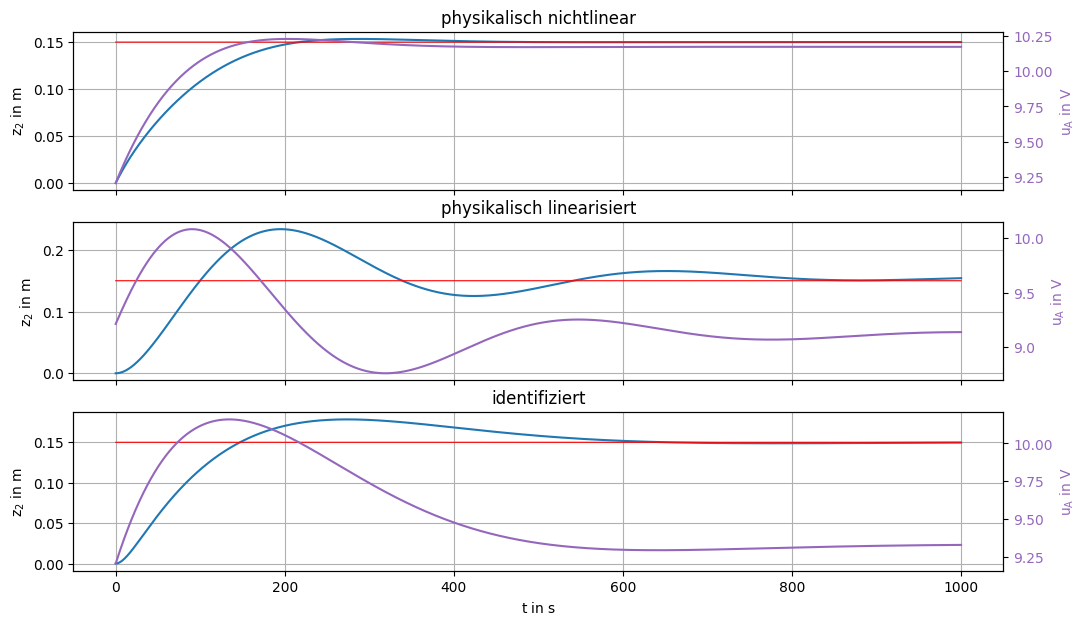

In [14]:
plt.close()

fig1, (axes10, axes20, axes30) = plt.subplots(3, 1, figsize=(12,7), sharex=True)

axes10.plot(timeDom, zPhyNichtLin[0, :], label='physikalisch nichtlinear')
axes10.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)
axes20.plot(timeDom, zPhyLin[0, :] + bz2Phy, label='physikalisch linearisiert')
axes20.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)
axes30.plot(timeDom, zMessung[0, :] + bz2Messung, label='identifiziert')
axes30.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)

axes11 = axes10.twinx()
axes21 = axes20.twinx()
axes31 = axes30.twinx()

axes11.plot(timeDom[:-1:], uPhyNichtLin[:-1:], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes21.plot(timeDom[:-1:], uPhyLin[:-1:], color='C4')
axes21.tick_params(axis='y', labelcolor='C4')

axes31.plot(timeDom[:-1:], uMessung[:-1:], color='C4')
axes31.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes20.set_ylabel(r'$z_2$ in m')
axes21.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes30.set_ylabel(r'$z_2$ in m')
axes31.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes30.set_xlabel(r'$t$ in s')

axes10.title.set_text('physikalisch nichtlinear')
axes20.title.set_text('physikalisch linearisiert')
axes30.title.set_text('identifiziert')

axes10.grid()
axes20.grid()
axes30.grid()
plt.show()

**Regler mit Steuerung**

In [15]:
regler.reset()

zPhyLin = np.zeros((2, len(timeDom)))
zPhyLin[:, 0] = z0 - np.array([bz2Phy, 0])
uPhyLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0PhyLin = zPhyLin[:, idx]
    z2r, uSteuerung = steuerung.run(_t)
    uRegler = regler.run(z2r, z0PhyLin[0])
    uPhyLin[idx] = uSteuerung + uRegler + buA
    
    resPhyLin = solve_ivp(linSys,
                          [timeDom[idx], timeDom[idx + 1]],
                          z0PhyLin,
                          args=(uPhyLin[idx], T1Phy, T2Phy, KPhy, buA))
    zPhyLin[:, idx + 1] = resPhyLin.y.T[-1, :]

In [16]:
regler.reset()

zPhyNichtLin = np.zeros((2, len(timeDom)))
uPhyNichtLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0PhyNichtLin = zPhyNichtLin[:, idx]
    z2r, uSteuerung = steuerung.run(_t)
    uRegler = regler.run(z2r, z0PhyNichtLin[0] - bz2Messung)
    uPhyNichtLin[idx] = uSteuerung + uRegler + buA

    resPhyNichtLin = solve_ivp(nonLinSys,
                               [timeDom[idx], timeDom[idx + 1]],
                               z0PhyNichtLin,
                               args=(uPhyNichtLin[idx], ))
    zPhyNichtLin[:, idx + 1] = resPhyNichtLin.y.T[-1, :]

In [17]:
regler.reset()

zMessung = np.zeros((2, len(timeDom)))
zMessung[:, 0] = z0 - np.array([bz2Messung, 0])
uMessung = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0Messung = zMessung[:, idx]
    z2r, uSteuerung = steuerung.run(_t)
    uRegler = regler.run(z2r, z0Messung[0])
    uMessung[idx] = uSteuerung + uRegler + buA

    resMessung = solve_ivp(linSys,
                           [timeDom[idx], timeDom[idx + 1]],
                           z0Messung,
                           args=(uMessung[idx], T1Messung, T2Messung, KMessung, buA))
    zMessung[:, idx + 1] = resMessung.y.T[-1, :]

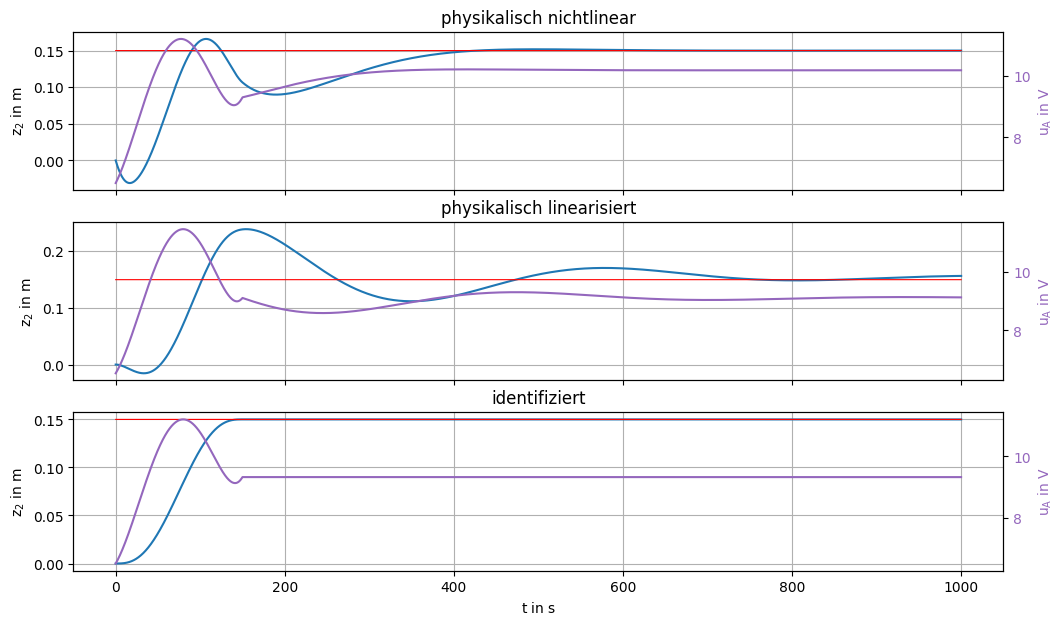

In [18]:
plt.close()

fig1, (axes10, axes20, axes30) = plt.subplots(3, 1, figsize=(12,7), sharex=True)

axes10.plot(timeDom, zPhyNichtLin[0, :], label='physikalisch nichtlinear')
axes10.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)
axes20.plot(timeDom, zPhyLin[0, :] + bz2Phy, label='physikalisch linearisiert')
axes20.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)
axes30.plot(timeDom, zMessung[0, :] + bz2Messung, label='identifiziert')
axes30.plot(timeDom, np.ones(len(timeDom)) * z2Soll, color='r', linewidth=0.8)

axes11 = axes10.twinx()
axes21 = axes20.twinx()
axes31 = axes30.twinx()

axes11.plot(timeDom[:-1:], uPhyNichtLin[:-1:], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes21.plot(timeDom[:-1:], uPhyLin[:-1:], color='C4')
axes21.tick_params(axis='y', labelcolor='C4')

axes31.plot(timeDom[:-1:], uMessung[:-1:], color='C4')
axes31.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes20.set_ylabel(r'$z_2$ in m')
axes21.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes30.set_ylabel(r'$z_2$ in m')
axes31.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes30.set_xlabel(r'$t$ in s')

axes10.title.set_text('physikalisch nichtlinear')
axes20.title.set_text('physikalisch linearisiert')
axes30.title.set_text('identifiziert')

axes10.grid()
axes20.grid()
axes30.grid()
plt.show()